In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2021-09-17 09:18:54.462177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-17 09:18:54.462250: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Download the dataset
# The dataset has two tap-separated files: cora.cites and cora.content.
# cora.cites includes the citation records with two columns: cited_paper_id (target) and citing_paper_id (source).
# cora.content includes the paper content records with 1,435 columns: paper_id, subject, and 1,433 binary features.


zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

172032/168052 [==============================] - 1s 6us/step


In [3]:
# Process and visualize the dataset
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [12]:
citations.sample(5).head()

,target,source
478,30,2191
4518,1207,2282
5388,1846,1845
3941,897,896
2244,332,845


In [5]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [7]:
print(papers.sample(5))

      paper_id  term_0  term_1  term_2  term_3  term_4  term_5  term_6  \
2545   1120138       0       0       0       0       0       0       0   
740      27627       0       0       0       0       0       0       0   
568       6217       0       0       0       0       0       0       0   
1197     27250       0       0       0       0       0       0       0   
1564     42847       0       0       0       0       0       0       0   

      term_7  term_8  ...  term_1424  term_1425  term_1426  term_1427  \
2545       0       0  ...          0          0          0          0   
740        0       0  ...          0          0          0          0   
568        0       0  ...          0          0          0          0   
1197       0       0  ...          0          0          0          0   
1564       0       0  ...          0          0          0          0   

      term_1428  term_1429  term_1430  term_1431  term_1432  \
2545          0          0          0          0     

In [8]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [9]:
# convert the paper ids and the subjects into zero-based indices.

class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [16]:
citations.sample(5).head()

,target,source
4603,1252,2584
3976,914,1330
3336,652,694
3971,909,1773
2842,493,1942


In [11]:
print(papers.sample(5))

      paper_id  term_0  term_1  term_2  term_3  term_4  term_5  term_6  \
1405      2431       0       0       0       0       0       0       0   
74          84       0       0       0       0       0       0       0   
144        573       0       0       0       0       0       0       0   
1940      1281       0       0       0       0       0       0       0   
1835      2262       0       0       0       0       0       0       0   

      term_7  term_8  ...  term_1424  term_1425  term_1426  term_1427  \
1405       0       0  ...          0          0          0          0   
74         0       0  ...          0          0          0          0   
144        0       0  ...          0          0          0          0   
1940       0       0  ...          0          0          0          0   
1835       0       0  ...          0          0          0          0   

      term_1428  term_1429  term_1430  term_1431  term_1432  subject  
1405          0          0          0        

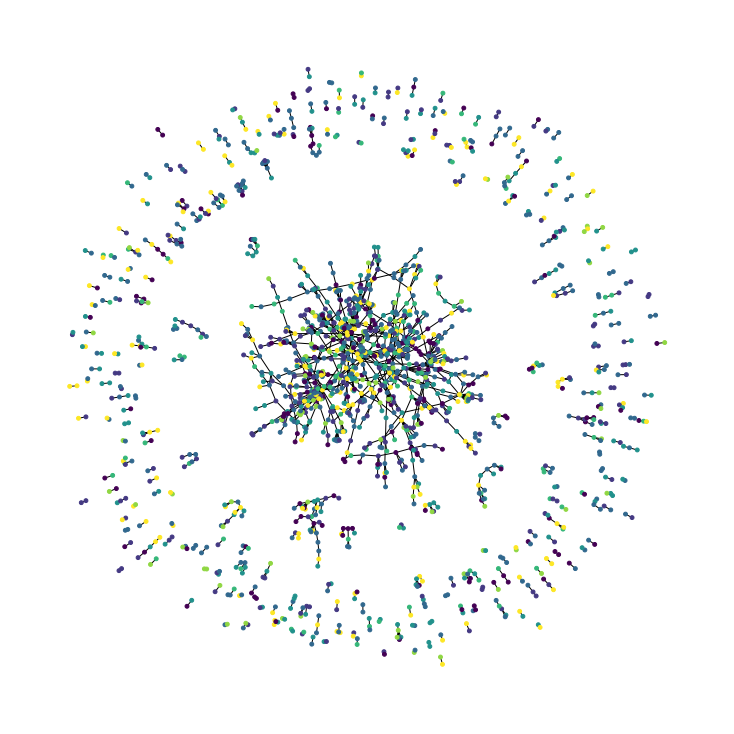

In [17]:
# visualize the citation graph. 
# Each node in the graph represents a paper, and the color of the node corresponds to its subject. 

plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500)) # only a sample is selected
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [18]:
# Split the dataset into stratified train and test sets

train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (1326, 1435)
Test data shape: (1382, 1435)


##  Train and Evaluate Experiment

In [20]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 50
batch_size = 256

In [21]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [29]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [24]:
# Implement Feedforward Network (FFN) Module

# BN -> Droupout -> Dense

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [25]:
# Prepare the data for the baseline NN model
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [26]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

2021-09-17 09:29:43.761613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-17 09:29:43.761638: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-17 09:29:43.761657: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (seetha-HP-348-G4): /proc/driver/nvidia/version does not exist
2021-09-17 09:29:43.761935: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     [(None, 1433)]       0                                            
__________________________________________________________________________________________________
ffn_block1 (Sequential)         (None, 32)           52804       input_features[0][0]             
__________________________________________________________________________________________________
ffn_block2 (Sequential)         (None, 32)           2368        ffn_block1[0][0]                 
__________________________________________________________________________________________________
skip_connection2 (Add)          (None, 32)           0           ffn_block1[0][0]                 
                                                                 ffn_block2[0][0]          

In [27]:
history = run_experiment(baseline_model, x_train, y_train)

2021-09-17 09:30:36.280893: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-17 09:30:36.322402: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz


Epoch 1/50
5/5 [==============================] - 5s 135ms/step - loss: 3.9740 - acc: 0.1420 - val_loss: 1.8454 - val_acc: 0.3015
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 2.7860 - acc: 0.2591 - val_loss: 1.8533 - val_acc: 0.3015
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 2.3831 - acc: 0.2600 - val_loss: 1.8583 - val_acc: 0.3015
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 2.2241 - acc: 0.2609 - val_loss: 1.8330 - val_acc: 0.3015
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 1.9932 - acc: 0.2964 - val_loss: 1.8258 - val_acc: 0.3015
Epoch 6/50
5/5 [==============================] - 0s 23ms/step - loss: 1.9157 - acc: 0.3221 - val_loss: 1.8191 - val_acc: 0.3015
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 1.8101 - acc: 0.3531 - val_loss: 1.8065 - val_acc: 0.3065
Epoch 8/50
5/5 [==============================] - 0s 26ms/step - loss: 1.7397 - acc: 0.3594 - va

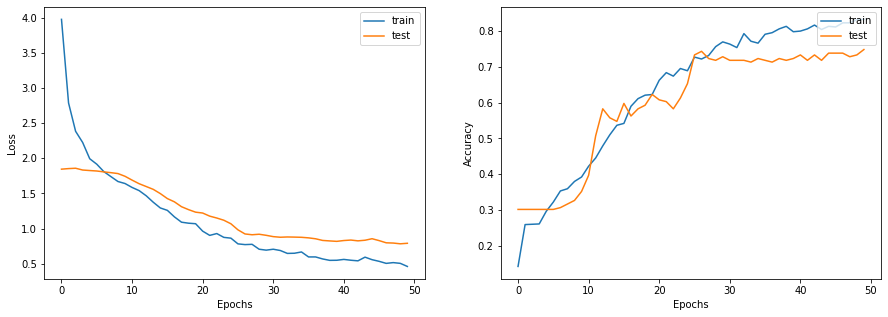

In [30]:
display_learning_curves(history)

In [31]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 75.4%


## Graph Neural Network Model


In [32]:
# Prepare the data for the graph model
# your dataset consists of a single graph that fits entirely in memory.

# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T

# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])

# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [33]:
# Implement a graph convolution layer

# Prepare: The input node representations are processed using a FFN to produce a message. 
# Apply linear transformation to the representations.

# Aggregate: The messages of the neighbours of each node are aggregated with respect to the edge_weights 
# using a permutation invariant pooling operation, such as sum, mean, and max, 
# to prepare a single aggregated message for each node. 
# See, for example, tf.math.unsorted_segment_sum APIs used to aggregate neighbour messages.

# Update: The node_repesentations and aggregated_messages—both of shape [num_nodes, representation_dim]— 
# are combined and processed to produce the new state of the node representations (node embeddings). 
# If combination_type is gru, the node_repesentations and aggregated_messages are stacked to create a sequence, 
# then processed by a GRU layer. Otherwise, the node_repesentations and aggregated_messages are added or 
# concatenated, then processed using a FFN.

class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="sum", # message
        combination_type="concat", # aggregation
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [34]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.squeeze(tf.gather(x, input_node_indices))
        # Compute logits
        return self.compute_logits(node_embeddings)

In [35]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.00335667 -0.10554906 -0.03287099  0.02924993  0.05444347 -0.00301438
   0.04367314]
 [-0.10908968 -0.04804103 -0.04509512  0.05536726  0.04349488  0.05468341
  -0.03510087]
 [-0.13746549  0.2149076  -0.3369352  -0.08563618  0.10639078  0.09007218
   0.17388788]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess (Sequential)      (2708, 32)                52804     
_________________________________________________________________
graph_conv1 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
graph_conv2 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
postprocess (Sequential)     (2708, 32)                2368      
____________________________________________________________

In [36]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/50
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
5/5 [==============================] - 5s 222ms/step - loss: 2.3165 - acc: 0.2041 - val_loss: 1.9232 - val_acc: 0.2814
Epoch 2/50
5/5 [==============================] - 1s 130ms/step - loss: 2.0192 - acc: 0.2653 - val_loss: 1.9200 - val_acc: 0.2663
Epoch 3/50
5/5 [==============================] - 1s 135ms/step - loss: 1.9209 - acc: 0.2875 - val_loss: 1.9164 - val_acc: 0.2864
Epoch 4/50
5/5 [==============================] - 1s 132ms/step - loss: 1.8849 - acc: 0.2964 - val_loss: 1.9086 - val_acc: 0.2412
Epoch 5/50
5/5 [==============================] - 1s 146ms/step - loss: 1.8561 - acc: 0.2955 - val_loss: 1.8996 - val_acc: 0.3015
Epoch 6/50
5/5 [==============================] - 1s 136ms/step - loss: 1.8773 - acc: 0.2990 - val_loss: 1.8886 - val_acc: 0.3015
Epoch 7/50
5/5 [==============================] - 1s 154ms/step - loss: 1.8446 - a

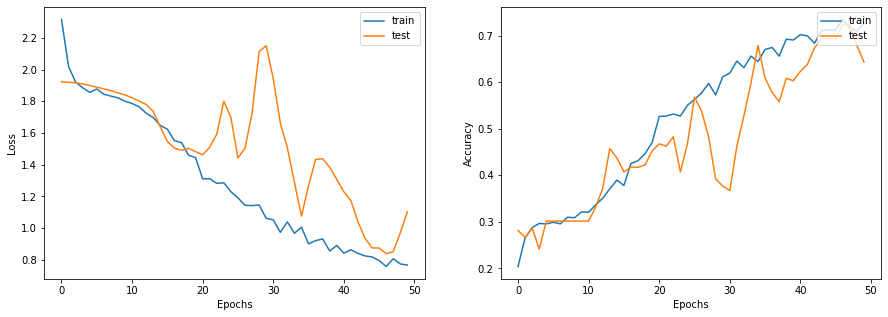

In [37]:
display_learning_curves(history)

In [38]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 62.45%


In [53]:
node_features[1].shape

TensorShape([1433])

#### Reference:

https://keras.io/examples/graph/gnn_citations